### Machine Learning Homework I 

### 1. Time Series Analysis with Linear Models

### By Nathmath Huang (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : March 22, 2025

`P. Libraries`

In [2]:
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Any
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as smARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# I have cuda
torch.cuda.is_available()

True

`P. Matrix Wrapper Library (self-implemented)`

In [4]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix:
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    
    def __add__(self, other):
        """
        Element-wise addition.
        """
        return self._apply_op(other, lambda a, b: a + b)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        return self._apply_op(other, lambda a, b: a - b)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        return self._apply_op(other, lambda a, b: a * b)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        return self.__mul__(other)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        return self._apply_op(other, lambda a, b: a / b)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def transpose(self):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.T
        else:
            result = self.data.transpose(1, 0)
        if len(self.shape) > 1:
            return Matrix(result.reshape(
                self.shape[1], self.shape[0]), backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([1, self.shape[0]]), backend=self._backend)
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)
        return Matrix(result, backend=backend, dtype=dtype)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented) [Not used directly by PCA here]`

In [5]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor:
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        return self._apply_op(other, lambda a, b: a + b)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        return self.__add__(other)

    def __sub__(self, other):
        """Element-wise subtraction."""
        return self._apply_op(other, lambda a, b: a - b)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        return self._apply_op(other, lambda a, b: a * b)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        return self.__mul__(other)

    def __truediv__(self, other):
        """Element-wise true division."""
        return self._apply_op(other, lambda a, b: a / b)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Tensor) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__mul__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        return Tensor(result, backend=self._backend)
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")

    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. BaseML Classes for all algorithms (self-implemented)`

In [6]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds


class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")


class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")


`P. Metrics for Regression Implementation (self-implemented)`

In [7]:
# This metrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class RegressionMetrics:
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse()
        elif self.metric_type == 'rmse':
            return self._compute_rmse()
        elif self.metric_type == 'mae':
            return self._compute_mae()
        elif self.metric_type == 'mape':
            return self._compute_mape()
        elif self.metric_type == 'r2':
            return self._compute_r2()
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2()
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _compute_mse(self) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** self.typeclass(2.0, backend = error._backend, device = error.device)
        mean_squared_error = squared_error.mean()
        return mean_squared_error
    
    def _compute_rmse(self) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** self.typeclass(2.0, backend = error._backend, device = error.device)
        mean_squared_error = squared_error.mean()
        rmse = mean_squared_error ** self.typeclass(0.5, backend = mean_squared_error._backend, device = mean_squared_error.device)
        return rmse
    
    def _compute_mae(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        mean_absolute_error = absolute_error.mean()
        return mean_absolute_error
    
    def _compute_mape(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        mean_absolute_percentage_error = absolute_percentage_error.mean()
        return mean_absolute_percentage_error
    
    def _compute_r2(self) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** self.typeclass(2.0, backend=error._backend, device=error.device)).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.mean()
        total_error = self.target - target_mean
        ss_tot = (total_error ** self.typeclass(2.0, backend=total_error._backend, device=total_error.device)).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = self.typeclass(1.0, backend=ss_res._backend, device=ss_res.device) - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = self.typeclass(1.0, backend=r2._backend, device=r2.device) - (
            (self.typeclass(1.0, backend=r2._backend, device=r2.device) - r2) *
            (self.typeclass(n - 1, backend=r2._backend, device=r2.device) /
             self.typeclass(n - self.k - 1, backend=r2._backend, device=r2.device))
        )
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


`P. ARIMAX Library (self-implmented)`

In [185]:
# This metrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class
class BaseTimeSeriesModel:
    
    def __init__(self, backend="numpy"):
        self.backend = backend.lower()
        
    def _is_matrix(self, data, *, raise_error: bool = False):
        """
        Checks whether the provided data is an instance of Matrix.
    
        Args:
            data (Any): The data to be checked.
            raise_error (bool, optional): If True and data is not a Matrix, raises ValueError. Defaults to False.
    
        Returns:
            bool: Whether the data is an instance of Matrix.
    
        Raises:
            ValueError: If `raise_error` is True and the data is not a Matrix.
        
        """
        if isinstance(data, Matrix):
            return True
        else:
            if raise_error == True:
                raise ValueError(f"Time series models require Matrix to be the input format. Try converting your data {type(data)} into a Matrix.")
            return False
    
    def _to_matrix(self, data):
        """
        Converts the input data into a Matrix object.
        
        Args:
            data: The input data which can be of various types including Matrix, Tensor, numpy.ndarray, and torch.Tensor.
        
        Returns:
            Matrix: A new Matrix object created from the input data.
        
        Raises:
            ValueError: If `data` is not an instance of Matrix (but Tensor).
        
        """
        if isinstance(data, Matrix):
            return data
        elif isinstance(data, Tensor):
            raise ValueError("Time series models only accept Matrix as the data type. Please convert to Matrix using data=Matrix(data.data)")
        elif isinstance(data, np.ndarray):
            return Matrix(data, backend=self.backend)
        elif isinstance(data, torch.Tensor):
            return Matrix(data, backend=self.backend)
        
        # Try to convert to Matrix anyway.
        return Matrix(data, backend=self.backend)
    
    @staticmethod
    def _create_lagged_matrices(series: Matrix, order: int) -> Matrix:
        """
        Constructs the regression design matrix X and target vector Y.
        For t from order to n-1, each row of X is [1, y[t-1], ..., y[t-order]].
        Y is the column vector [y[t]].
    
        Args:
            series (Matrix): The time series data with a 'data' attribute for values.
            order (int): Number of lags to include in the lagged features.
    
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices. 
                                  The first matrix is the feature matrix X with lagged values and possibly an intercept,
                                  and the second matrix is the target vector Y consisting of the original time series data.
        
        """
        
        # Series.data is a 1D array or 1D tensor.
        if len(series.shape) > 1:
            if len(series.shape) == 2 and series.shape[1] == 1:
                series = series.flatten()
            else:
                raise ValueError("To create a lagged matrix, input data must be a 1D array")
        n = series.shape[0]
        X_list, Y_list = [], []
        
        # Loop over time indices where lagged values are available.
        for t in range(order, n):
            # Build lag vector in reverse order so that the most recent observation is first.
            if series._is_numpy:
                lag = series.data[t-order:t][::-1]  # reverse order
                row = np.concatenate(([1], lag))
            else:
                # For torch, use tensor operations. We assume torch is available.
                lag = series.data[t-order:t].flip(0)  # flip to reverse the order
                row = torch.cat((torch.tensor([1], dtype=series.data.dtype), lag))
            X_list.append(row)
            Y_list.append(series.data[t])
            
        if series._is_numpy:
            X = Matrix(np.array(X_list), backend=series._backend, dtype=series.dtype, device=series.device)
            Y = Matrix(np.array(Y_list).reshape(-1, 1), backend=series._backend, dtype=series.dtype, device=series.device)
        else:
            X = Matrix(torch.stack(X_list), backend=series._backend, dtype=series.dtype, device=series.device)
            Y = Matrix(torch.tensor(Y_list, dtype=series.data.dtype).unsqueeze(1), backend=series._backend, dtype=series.dtype, device=series.device)
        return X, Y

    @staticmethod
    def _differencing(series: Matrix, d: int, axis: int = 0) -> Matrix:
        """
        Difference the input series d times.
        
        Args:
            series (Matrix): The original n-dimensional time series data.
            d (int): The number of times to difference the data.
            axis (int): The axis to difference the data.
            
        Returns:
            Matrix: The differenced time series. Lost elements will be padded to NaN.
        """
        diff_matrix = series.copy()
        
        # Only 1 dimension, regard as a single array.
        if len(diff_matrix.shape) == 1:

            # Differencing for d times.
            for i in range(d):
                # For a 1D time series, compute differences between consecutive elements.
                diff_matrix = diff_matrix[1:] - diff_matrix[:-1]
            
            # Padding elems.
            pad = Matrix(np.repeat(np.NaN, d), backend=series._backend, dtype=series.dtype, device=series.device)
            
            return pad.append(diff_matrix)
        
        # Perform differencing d times along the given axis.
        # Default: axis = 0, along the row sequence.
        else:
            for i in range(d):
                # Create slicers for the two parts of the array.
                slicer1 = [slice(None)] * len(diff_matrix.shape)
                slicer2 = [slice(None)] * len(diff_matrix.shape)
                slicer1[axis] = slice(1, None)     # from index 1 to the end along axis
                slicer2[axis] = slice(None, -1)    # from index 0 to one before the end along axis
                
                # Compute the difference along the axis.
                diff_matrix = diff_matrix[tuple(slicer1)] - diff_matrix[tuple(slicer2)]
            
            # Determine the shape for the padding: same as original shape except the given axis has length d.
            pad_shape = list(series.shape)
            pad_shape[axis] = d
            
            # Create a padding matrix filled with NaN.
            pad = Matrix(np.full(pad_shape, np.NaN), backend=series._backend, dtype=series.dtype, device=series.device)
            
            return pad.append(diff_matrix, axis=axis)


# ARIMAX Implementation
class ARIMAX(BaseTimeSeriesModel):
    """
    ARIMAX model class that implements ARIMA with exogenous regressors.
    The model is defined as:
    
        φ(B)(1-B)^d y_t = β' x_t + θ(B) ε_t
    
    where φ(B) represents the AR part, (1-B)^d is the differencing operator,
    β' x_t includes exogenous variables, and θ(B) is the MA component.
    
    This class is modularized so that functions for differencing, AR estimation,
    and MA estimation (via iterative non-linear fitting, Kalman filter, and MLE)
    can be reused or extended in future subclasses.
    """
    def __init__(self, p=1, d=0, q=0, constant=True, backend="numpy",* ,
                 lr=1e-3, tol=1e-8, max_iter=1000, delta=1e-8):
        """
        Initializes the ARIMAX model.
        
        Args:
            p (int): Order of the autoregressive part.
            d (int): Degree of differencing.
            q (int): Order of the moving average part.
            backend (str): Computational backend ("numpy" or "torch").
            lr (float): Learning rate when doing MA estimation.
            tol (float): Convergence threshold when doing MA estimation.
            max_iter (int): Max number of iterations allowed to be performed when doing MA estimation.
            delta (float): Micro-element to compute gradient offset to the original vector when doing MA estimation.
        """
        super().__init__(backend)
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter
        self.delta = delta
        # Model Realted
        self.p = p                  # AR order
        self.d = d                  # Differencing order
        self.q = q                  # MA order
        self.ar_params = None       # AR coefficients (including intercept)
        self.ma_params = None       # MA coefficients
        self.beta_params = None     # Coefficients for exogenous regressors
        # Data Related
        self.fitted = False         # Whether fitted or not
        self.residuals = None       # Residuals after ARX estimation
        self.original_y = None      # The original data used to fit
        self.differenced_y = None   # The data used to fit after differencing
        self.exogen_matrix = None   # The exogeneous data used to fit
        # Interim Data
        self.X_ar = None            # X_ar matrix computed during the AR estimation
        self.X_aligned = None       # X_aligned matrix computed during the AR estimation
        self.Y_ar = None            # Y_ar matrix computed during the AR estimation

    def _estimate_ar_beta(self, series: Matrix, exogenous: Matrix = None):
        """
        Estimate AR and beta coefficients via least squares on the differenced data.
        Uses lagged matrices for AR terms and appends exogenous regressors if provided.
        
        Args:
            series (Matrix): The (differenced) time series.
            exogenous (Matrix or None): Matrix of exogenous regressors.
        
        Returns:
            tuple(Matrix, Matrix, Matrix): A tuple containing the estimated 
            parameters for AR (including intercept), beta coefficients, and the 
            residuals from the ARX regression.
            
        Raises:
            ValueError: If the input data is not a Matrix.
            ValueError: If the exogenous matrix does not have the same 1st dimension with series.
            
        """
        # We check Matrix format strictly (raises error if mismatched)
        if self._is_matrix(series, raise_error=True) == False:
            pass
        if exogenous is not None:
            if self._is_matrix(exogenous, raise_error=True) == False:
                pass
        
        # Check dimension, if original input series and matrix does not have the same 1st dimension
        if exogenous is not None:
            exogenous = self._to_matrix(exogenous)
            if exogenous.shape[0] != series.shape[0]:
                raise ValueError(f"Time series data and exgenous matrix should have the same 1st dimension but are {exogenous.shape[0]} and {series.shape[0]} respectively")
        
        # If differenced, drop the first self.d elements.
        if self.d > 0:
            series = series[self.d:]
            if exogenous is not None:
                exogenous = exogenous[self.d:]
        
        # Create lagged matrix for AR estimation using BaseTimeSeriesModel's method.
        self.X_ar, self.Y_ar = self._create_lagged_matrices(series, order=self.p)
        
        # If exogenous regressors are provided, align and augment the design matrix.
        if exogenous is not None:
            # Align exogenous data with the lagged design (drop first self.p rows)
            exog_aligned = exogenous[self.p:]
            # Augment the AR design matrix with exogenous columns
            if len(exog_aligned.shape) == 1:
                exog_aligned = exog_aligned.reshape([-1,1])
            self.X_aligned = self.X_ar.hstack(exog_aligned)
        else:
            self.X_aligned = self.X_ar.copy()

        # Solve for parameters using the Matrix class least_square static method.
        params = Matrix.least_square(self.X_aligned, self.Y_ar, backend=self.backend, dtype=series.dtype)
        
        # Separate parameters: first (p+1) are for AR (including intercept) and the rest for beta.
        ar_params = params[:self.p+1]
        beta_params = None
        if exogenous is not None and params.shape[0] > (self.p+1):
            beta_params = params[self.p+1:]
            
        # Compute residuals: residuals = Y_ar - (X * params)
        X_params = self.X_aligned @ params
        residuals = self.Y_ar - X_params
        
        #      AR PARAMS, EXOG PARAMS, RESID
        return ar_params, beta_params, residuals

    def _estimate_ma_iterative(self, residuals: Matrix):
        """
        Estimate MA coefficients using an iterative non-linear fitting procedure.
        
        Args:
            residuals (Matrix): The residuals from ARX estimation.
        
        Returns:
            Matrix: The estimated MA coefficients.
        """
        n = residuals.shape[0]
        
        # Build the lag matrix.
        lagged, actual = self._create_lagged_matrices(residuals, order=self.q)
        
        # Get away the 1s in the lagged
        lagged = lagged[:,1:]
        
        # Transform it into standard normal
        lagged_std = lagged.std()
        lagged = lagged / lagged_std
        actual = actual / lagged_std
        
        # Initialize MA coefficients theta as zeros.
        theta = Matrix.zeros((self.q, 1), backend=self.backend).to(backend=self.backend, dtype=residuals.dtype, device=residuals.device)
        prev_loss = float('inf')
        
        # Iterative optimization loop.
        for iteration in range(self.max_iter):
            # Vectorized prediction: shape (n - q, 1) = lagged dot theta
            predictions = lagged @ theta
            
            # Compute the error and loss (mean squared error)
            error = actual - predictions
            loss = (error.transpose().__matmul__(error)).data[0, 0] / (n - self.q)
            
            # Check for convergence.
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
            
            # Finite differences: estimate the gradient for each theta_i.
            # Instead of looping over each theta, we note that for each column i,
            # predictions_plus = predictions + delta * lagged[:, i]
            # so error_plus = error - delta * lagged[:, i]
            # We compute the loss for each parameter in a vectorized manner.
            error_array = error.data.reshape(-1)           # shape: (n - q,)
            # lagged.data has shape (n - q, q)
            # Compute loss_plus for each parameter i:
            loss_plus_array = np.mean((error_array.reshape(-1, 1) - self.delta * lagged.data)**2, axis=0)  # shape: (q,)
            grad_array = (loss_plus_array - loss) / self.delta     # finite-difference approximation (shape: (q,))
            
            # Wrap the gradient as a Matrix and update theta.
            grad = Matrix(grad_array.reshape(self.q, 1), backend=self.backend)
            theta = theta - (grad * self.lr)
        
        return theta * lagged_std

    def _estimate_ma_kalman(self, residuals: Matrix):
        """
        Estimate MA coefficients using a Kalman filter based approach.
        The ARIMA model is recast in state-space form and the filter is used to estimate the latent MA effects.
        
        Args:
            residuals (Matrix): The residuals from ARX estimation.
        
        Returns:
            Matrix: The estimated MA coefficients.
        """
        # Initialize state-space parameters.
        n = len(residuals.data)
        # For simplicity, we assume the state vector size equals q.
        state = Matrix.zeros((self.q, 1), backend=self.backend)
        covariance = Matrix.zeros((self.q, self.q), backend=self.backend)
        process_noise = 0.01
        measurement_noise = 0.1
        
        # Placeholder: accumulate information to infer MA coefficients.
        # In practice, one would define a proper state transition and observation model.
        theta_sum = Matrix.zeros((self.q, 1), backend=self.backend)
        count = 0
        
        for t in range(self.q, n):
            # Prediction step: Here, we assume identity transition for simplicity.
            state_pred = state  # state prediction (could be state transition matrix * state)
            covariance_pred = covariance  # plus process noise: covariance + process_noise * I
            if self.backend == "numpy":
                covariance_pred = covariance_pred + Matrix(process_noise * np.eye(self.q), backend=self.backend)
            else:
                # For torch, assume similar operation.
                covariance_pred = covariance_pred + Matrix(process_noise * np.eye(self.q), backend=self.backend)
            
            # Observation: actual residual at time t.
            innovation = Matrix([[residuals.data[t]]], backend=self.backend)  # scalar as a 1x1 matrix
            
            # Kalman gain calculation (using simplified scalar observation model)
            # Here, observation matrix H is assumed to be [1, 0, ..., 0]
            H = Matrix([[1] + [0]*(self.q-1)], backend=self.backend)
            S = H.__matmul__(covariance_pred).__matmul__(H.transpose()) + Matrix([[measurement_noise]], backend=self.backend)
            # Inverse S is computed via Matrix.inverse (assuming S is 1x1).
            K = covariance_pred.__matmul__(H.transpose()).__matmul__(S.inverse())
            
            # Update step: update state with innovation scaled by Kalman gain.
            state = state_pred + K.__matmul__(innovation - H.__matmul__(state_pred))
            covariance = (Matrix.zeros((self.q, self.q), backend=self.backend) - K.__matmul__(H)).__matmul__(covariance_pred)
            
            # Accumulate state estimates to infer MA coefficients.
            theta_sum = theta_sum + state
            count += 1
        
        # Average state estimates as the final MA coefficient estimates.
        theta_est = theta_sum * (1.0 / count)
        return theta_est

    def _estimate_ma_mle(self, residuals: Matrix):
        """
        Estimate MA coefficients using Maximum Likelihood Estimation (MLE).
        The likelihood function is optimized iteratively via a numerical method.
        
        Args:
            residuals (Matrix): The residuals from ARX estimation.
        
        Returns:
            Matrix: The estimated MA coefficients.
        """        
        # Build the lag matrix.
        lagged, actual = self._create_lagged_matrices(residuals, order=self.q)
        
        # Get away the 1s in the lagged
        lagged = lagged[:,1:]
        
        # Transform it into standard normal
        lagged_std = lagged.std()
        lagged = lagged / lagged_std
        actual = actual / lagged_std
                
        # Initialize MA coefficients theta as zeros.
        theta = Matrix.zeros((self.q, 1), backend=self.backend).to(backend=self.backend, dtype=residuals.dtype, device=residuals.device)
        prev_ll = -float('inf')
        
        # Iterative optimization loop.
        for iteration in range(self.max_iter):
            # Compute predicted values using vectorized multiplication.
            # predicted shape: (n - q, 1) = lagged dot theta
            predicted = lagged @ theta
            error = actual - predicted
            # Pseudo log-likelihood: negative sum of squared errors.
            ll = error.transpose() @ error
            ll = float(-ll.data[0, 0])
            
            # Check convergence.
            if abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll
            
            # Numerical gradient computation
            delta = self.delta
            # Instead of looping over each parameter, perturb all simultaneously.
            # Create a (q, q) identity matrix; each column will correspond to perturbing one parameter.
            I = Matrix.identity(self.q, backend=self.backend).to(backend=self.backend, dtype=residuals.dtype, device=residuals.device)
            
            # Broadcast theta: shape (q, 1) + delta * I => shape (q, q), where each column is a perturbed theta.
            theta_plus = theta.data + delta * I  # shape: (q, q)
            
            # Compute predictions for each perturbed theta in one go:
            # lagged.data: (n - q, q), theta_plus: (q, q) -> result: (n - q, q)
            predictions_plus = lagged.data @ theta_plus
            
            # Each column corresponds to predictions when a single parameter is perturbed.
            # Compute errors for each variant.
            error_plus = actual.reshape([-1, 1]) - predictions_plus  # shape: (n - q, q)
            
            # Compute the loss (negative SSE) for each perturbation.
            # Sum the squared errors along the time dimension.
            ll_plus = error_plus**2
            ll_plus = -ll_plus.sum(axis=0) # shape: (q,)
            
            # Finite-difference gradient for each parameter.
            grad_array = (ll_plus - ll) / delta  # shape: (q,)
            grad = grad_array.reshape([self.q, 1])
            
            # Gradient ascent step (to maximize the likelihood).
            theta = theta + (grad * self.lr)
        
        return theta * lagged_std

    def fit(self, y: Matrix | Any, exogenous: Matrix | Any = None, ma_method='mle'):
        """
        Fit the ARIMAX model on the provided time series and exogenous data.
        
        Args:
            y (Matrix or array-like): The time series data.
            exogenous (Matrix or array-like or None): The exogenous regressor data.
            ma_method (str): The method for MA estimation ('iterative', 'kalman', or 'mle').
        
        Returns:
            self: Fitted ARIMAX model with estimated parameters.
        """
        # For API methods, we allow inputs to be convertable.
        
        # Convert inputs to Matrix objects.
        y_matrix = self._to_matrix(y)
        self.original_y = y_matrix.copy()
        
        # Convert exog matrix to Matrix objects.
        if exogenous is not None:
            exog_matrix = self._to_matrix(exogenous)
        else:
            exog_matrix = None
        self.exogen_matrix = exog_matrix.copy() if exog_matrix is not None else None
        
        # Difference the series if required.
        if self.d > 0:
            diff_y = self._differencing(y_matrix, self.d)
        else:
            diff_y = y_matrix
        self.differenced_y = diff_y.copy()
        
        # Estimate AR and beta parameters via least squares.
        self.ar_params, self.beta_params, self.residuals = self._estimate_ar_beta(diff_y, exog_matrix)
        
        # Estimate MA parameters using the chosen method.
        if self.q > 0:
            if ma_method.lower() == 'iterative':
                self.ma_params = self._estimate_ma_iterative(self.residuals)
            elif ma_method.lower() == 'kalman':
                self.ma_params = self._estimate_ma_kalman(self.residuals)
            elif ma_method.lower() == 'mle':
                self.ma_params = self._estimate_ma_mle(self.residuals)
            else:
                raise ValueError("Unsupported MA estimation method. Choose one from 'iterative', 'kalman', or 'mle'.")
        else:
            self.ma_params = None
        
        self.fitted = True
        return self

    def predict(self, steps: int, exogenous_future: Matrix | Any = None):
        """
        Predict future values using the fitted ARIMAX model.
        
        The forecasting procedure iterates step-by-step. For each forecast step,
        it computes the AR component using the intercept and lagged values,
        adds the exogenous contribution (if available) and assumes the future 
        MA error contributions to be zero. If differencing was applied during fit,
        the forecasted differenced values are integrated back to the original scale
        using the Matrix.cumsum method.
        
        Args:
            steps (int): The number of steps ahead to forecast.
            exogenous_future (Matrix or array-like or None): Future values for exogenous regressors.
            
        Returns:
            Matrix: Forecasted values as a column vector.
            
        Raises:
            ValueError: If the model is not fitted or if exogenous_future dimensions do not match steps.
        """
        # Ensure the model has been fitted.
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction.")
        
        # Process future exogenous regressors if they were used in training.
        if self.beta_params is not None:
            if exogenous_future is None:
                raise ValueError("Exogenous regressors were used during training; exogenous_future must be provided for forecasting.")
            exog_future = self._to_matrix(exogenous_future)
            if exog_future.shape[0] != steps:
                raise ValueError(f"exogenous_future must have {steps} rows, got {exog_future.shape[0]}")
            if len(exog_future.shape) == 1:
                exog_future = exog_future.reshape([-1, 1])
        else:
            exog_future = None

        # Retrieve the last p values from the differenced series if d>0, else from original series.
        if self.d > 0:
            # For forecasting, we use the differenced series used during fit.
            history = self.differenced_y.data.tolist()  # converting to a list for easier indexing
        else:
            history = self.original_y.data.tolist()
            
        # Prepare an empty list to store residual terms
        residual_diff = None
        if self.q > 0:
            residual_diff = self.residuals[-self.q:]
        
        # Prepare an empty list to store forecasted values for the differenced series.
        forecast_diff = []

        # For each forecast step, compute the AR forecast iteratively.
        for step in range(steps):
            # Construct the regressor vector:
            # The vector comprises [1, y_{t-1}, y_{t-2}, ..., y_{t-p}].
            # Use historical data when available, otherwise use previously forecasted values.
            # We take the last p observations from 'history' (which includes prior forecasts).
            if len(history) < self.p:
                raise ValueError("Not enough historical data to perform prediction.")
            recent_vals = history[-self.p:]
            # Reverse the order to match the lag ordering (most recent first).
            recent_vals_reversed = recent_vals[::-1]
            # Create the base regressor vector with intercept.
            regressor_list = [1] + recent_vals_reversed
            regressor = Matrix(regressor_list, backend=self.backend)
            regressor = regressor.reshape((1, len(regressor_list)))  # shape: (1, p+1)
            
            # If exogenous regressors are used, append the corresponding future row.
            if exog_future is not None:
                # Extract the exogenous row for the current forecast step.
                exog_row = exog_future[step]
                # Ensure exog_row is a Matrix row.
                exog_row = Matrix(exog_row, backend=self.backend)
                exog_row = exog_row.reshape((1, exog_future.shape[1]))
                # Augment the regressor vector.
                regressor = regressor.hstack(exog_row)
            
            # Combine AR and exogenous parameters.
            # The estimated parameters are stored as:
            #   - self.ar_params: shape (p+1, 1)
            #   - self.beta_params: shape (n_exog, 1) if exogenous regressors exist.
            if self.beta_params is not None:
                params = self.ar_params.vstack(self.beta_params)
            else:
                params = self.ar_params

            # Forecasted AR value is given by regressor * params (matrix multiplication).
            forecast_value = (regressor @ params).data[0, 0]
            
            # Forecasted MA value is iteratively determined
            if self.q > 0 and residual_diff is not None:
                forecast_value += float((self.ma_params.transpose() @ residual_diff)[0,0])
                # Shift up 1 row
                residual_diff_shape = (1, residual_diff.shape[1])
                residual_diff = residual_diff[1:]
                residual_diff = Matrix.zeros(residual_diff_shape).append(residual_diff)
                
            # Append the forecasted differenced value.
            forecast_diff.append(forecast_value)
            # Update history with the forecast value so that it can be used in later steps.
            history.append(forecast_value)
        
        # If differencing was applied during training, integrate the forecasts.
        if self.d > 0:
            # Rebuild the chain of differenced series starting from the original series.
            chain = [self.original_y]
            for i in range(self.d):
                chain.append(self._differencing(chain[-1], 1))
            # Now, chain[0] is the original series, chain[1] is the first difference, ..., chain[d] is the dth difference.
            # The forecasts we produced (forecast_diff) are for the dth differenced series.
            forecast_matrix = Matrix(forecast_diff, backend=self.backend).reshape((steps, 1))
            # To integrate, iterate from the dth difference back to the original scale.
            # For each integration step, add the last observed value from the appropriate differenced series.
            for level in range(self.d):
                # For integration, use the last observed value from chain[d - level - 1].
                last_val = chain[self.d - level - 1].data[-1]
                forecast_matrix = forecast_matrix.cumsum() + Matrix([[last_val]], backend=self.backend)
            return forecast_matrix.reshape((steps, 1))
        else:
            return Matrix(forecast_diff, backend=self.backend).reshape((steps, 1))

    def summary(self):
        """
        Print a summary of the ARIMAX model, including parameter estimates and t-test results.
        """
        if not self.fitted:
            print("Model is not fitted yet.")
            return

        print("========== ARIMAX Model Summary ==========")
        print(f"Model Orders: AR(p={self.p}), d={self.d}, MA(q={self.q})")
        print("----- AR Parameters (including intercept) -----")
        print(self.ar_params.data)
        if self.beta_params is not None:
            print("----- Beta (Exogenous) Parameters -----")
            print(self.beta_params.data)
        if self.ma_params is not None:
            print("----- MA Parameters -----")
            print(self.ma_params.data)


`1. Data Exploration & Preprocessing`

In [9]:
# Load the provided quarterly GDP dataset (1947-2023)
#

# Define the URL.
gdp_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/FRED_US_GDP_Quarterly.csv'

# Load the raw GDP dataset into a pandas DataFrame.
raw_gdp = pd.read_csv(gdp_url)

# Convert the "observation_date" column to string type and set it as the index of the DataFrame.
raw_gdp["observation_date"] = raw_gdp["observation_date"].astype(str)
raw_gdp.index = raw_gdp["observation_date"]

# Extract only the "GDP_Billion" column from the DataFrame, which contains GDP values in billions of dollars.
raw_gdp = raw_gdp["GDP_Billion"]

# Select and store a subset of the GDP data between January 1947 and October 2023. 
selected_gdp = raw_gdp.loc["1947-01-01":"2023-10-01"]

# Retransform into a DataFrame
dataframe_gdp = pd.DataFrame(selected_gdp)
dataframe_gdp

,GDP_Billion
observation_date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2022-10-01,26734.277
2023-01-01,27164.359
2023-04-01,27453.815


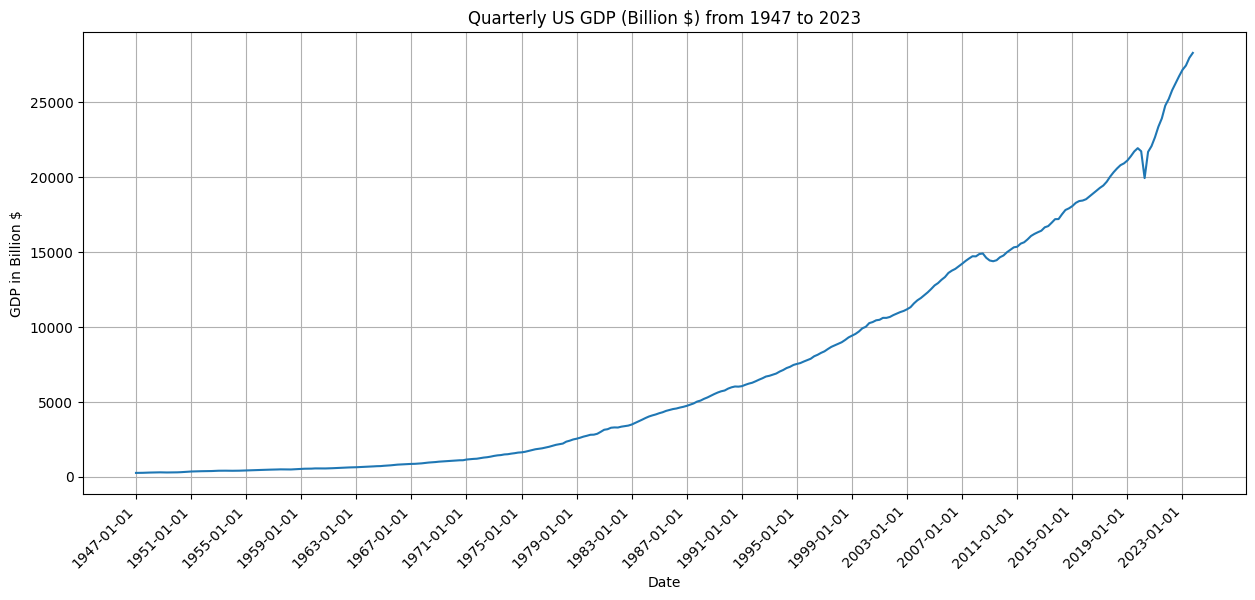

In [10]:
# Create time series plots of the data
#

# Create a plot canvas
plt.figure(figsize=(15,6))
plt.plot(selected_gdp.index, selected_gdp.values)
plt.title('Quarterly US GDP (Billion $) from 1947 to 2023')
plt.xlabel('Date')
plt.ylabel('GDP in Billion $')
plt.grid(True)

# Enhance the plot for better readability and aesthetics.
plt.xticks(rotation=45, ha='right')

# Create a more readable x-axis by labeling every few quarters
quartiles = selected_gdp.index[::16]  
quarter_labels = ["" if pd.to_datetime(x).year % 4 == 0 else x for x in quartiles]
plt.xticks(quartiles, quarter_labels)
plt.grid(True)

# Plot it
plt.show()

`2. Model Determination`

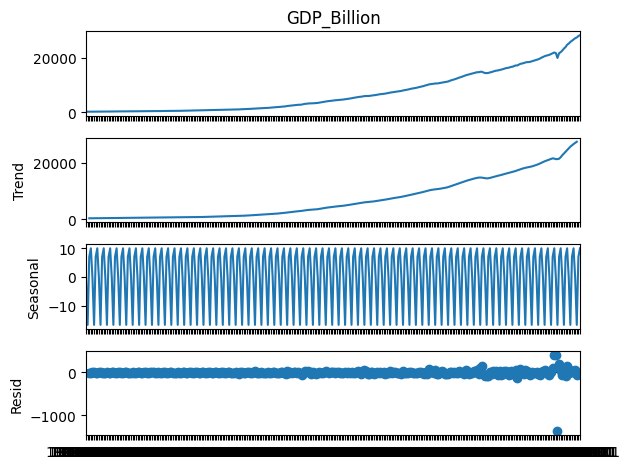

In [11]:
# Decompose the series into trend, seasonal, and residual components.
#

# Decomposition into trend and seasonal.
gdp_seasonal_decomposed = seasonal_decompose(dataframe_gdp["GDP_Billion"], model='additive', period=4)
gdp_seasonal_plot = gdp_seasonal_decomposed.plot()

# Reason for using "additive":
# The additive model is Y[t] = T[t] + S[t] + e[t]
# It is suitable because the seasonal effect typically remains consistent over time for GDP data.
# And in fact, we have observed that the seasonality does not change with the trend by the plot below.
# Moreover, by tring to set it to multiplicative, we have observed a systematic bias which has a clustered
#  and non-zero-mean residual, meaning it is not suitable for using multiplicative models.

# However, it should be noted that the seasonality is NOT significant.
# We will show this in the next few sections.

In [12]:
# Test for stationarity using the Augmented Dickey-Fuller test
# 

# ADF Test using adfuller.
def adf_test_adfuller(series, maxlag = 10, regression = "ct", autolag = "aic") -> dict:
    """
    Conducts the Augmented Dickey-Fuller test on a time series.
    
    Parameters:
        - series (pandas Series): The time series data.

    Returns:
        - dict: ADF statistic, p-value, and critical values for 1%, 5%, and 10% significance levels, AIC.
    """
    adf_result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag) 
    
    # Extracting the results
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    aic_value = adf_result[5]
    
    return {"adf": adf_statistic, 
            "p_value": p_value, 
            "critical_values": critical_values,
            "aic_value": aic_value}

# Perform an ADF by using adfuller.
undifferentiated_adf = adf_test_adfuller(dataframe_gdp["GDP_Billion"], 16, regression = "ct")
if undifferentiated_adf["p_value"] < 0.05:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 4)} \nThe null hypothesis can be rejected, suggesting general STATIONARITY.')
else:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 4)} \nThe null hypothesis cannot be rejected, suggesting generall NON-STATIONARITY.')

# It is obviously not stationary since the nominal GDP has a S-shaped growing trend.
# The result is what we expected and therefore we expect the d parameter of ARIMA greater than 0.

P-value=1.0 
The null hypothesis cannot be rejected, suggesting generall NON-STATIONARITY.


P-value=1.51137e-11 
The null hypothesis can be rejected, suggesting general STATIONARITY.


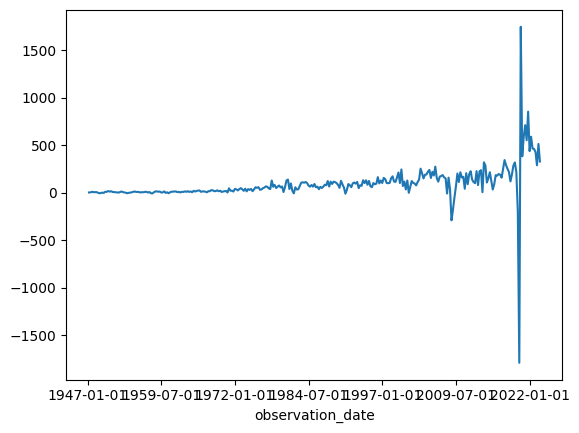

In [13]:
# Test for stationarity - Finding the differencing parameter d
#

# Let us conduct a first-order differencing.
dataframe_gdp["GDP_Billion_d1"] = dataframe_gdp["GDP_Billion"] - dataframe_gdp["GDP_Billion"].shift(1)
dataframe_gdp["GDP_Billion_d1"].plot()

# Perform an ADF by using adfuller.
undifferentiated_adf = adf_test_adfuller(dataframe_gdp["GDP_Billion_d1"].dropna(), 16, regression = "ct")
if undifferentiated_adf["p_value"] < 0.05:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 16)} \nThe null hypothesis can be rejected, suggesting general STATIONARITY.')
else:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 4)} \nThe null hypothesis cannot be rejected, suggesting general NON-STATIONARITY.')

# When we conduct the first-order detrend, we have found that it is generally stationary, although
# there are still some little trend there. We decide to difference one more time.

P-value=8.32315256e-08 
The null hypothesis can be rejected, suggesting general STATIONARITY.


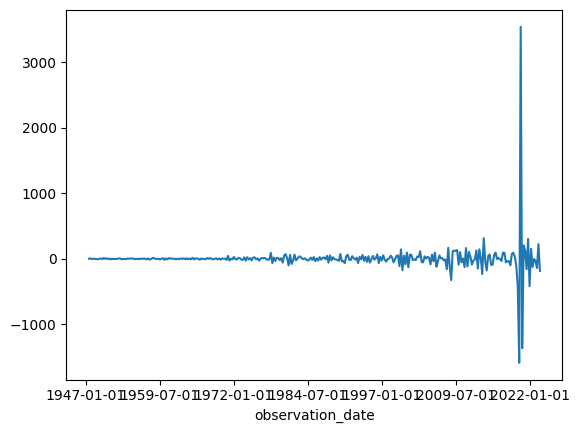

In [14]:
# Test for stationarity - Finding the differencing parameter d
#

# Let us conduct a first-order differencing.
dataframe_gdp["GDP_Billion_d2"] = dataframe_gdp["GDP_Billion_d1"] - dataframe_gdp["GDP_Billion_d1"].shift(1)
dataframe_gdp["GDP_Billion_d2"].plot()

# Perform an ADF by using adfuller.
undifferentiated_adf = adf_test_adfuller(dataframe_gdp["GDP_Billion_d2"].dropna(), 16, regression = "ct")
if undifferentiated_adf["p_value"] < 0.05:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 16)} \nThe null hypothesis can be rejected, suggesting general STATIONARITY.')
else:
    print(f'P-value={np.round(undifferentiated_adf["p_value"], 4)} \nThe null hypothesis cannot be rejected, suggesting general NON-STATIONARITY.')

# After detrending for 2 times, the plot indicates that it is stationary enough.
# We decide to stop here and use 2 as the differencing parameter.

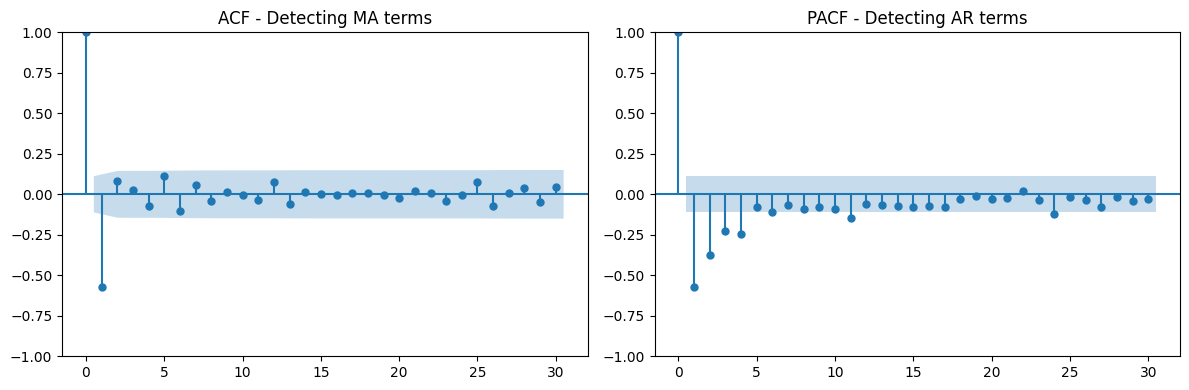

In [15]:
# Analyze ACF/PACF plots to determine appropriate p, q parameters
#

# Plot ACF and PACF for the GDP time series.
fig, subplots = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot helps in identifying the MA(q) order; significant spikes that cut off after lag q indicate an MA process of order q.
plot_acf(dataframe_gdp["GDP_Billion_d2"].dropna(), lags=30, ax=subplots[0])
subplots[0].set_title("ACF - Detecting MA terms")

# PACF plot helps in identifying the AR(p) order; significant spikes that cut off after lag p indicate an AR process of order p.
plot_pacf(dataframe_gdp["GDP_Billion_d2"].dropna(), lags=30, ax=subplots[1], method='ywm')
subplots[1].set_title("PACF - Detecting AR terms")
plt.tight_layout()
plt.show()

# Let's first see MA's result from ACF. We found it spikes at the 1st order; therefore MA's q should be set to 1.
# Let's then see AR's result from PACF. We found it spikes at the first fews and decay exponentially. Since we have done
#  differencing for twice, we regard it as generally stationary. So let's select the first two orders that are 
#  especially large - AR's term be set to 2.
# Until new, we conclude for ARMA's parameter, we have (p, d, q) = (2, 2, 1)

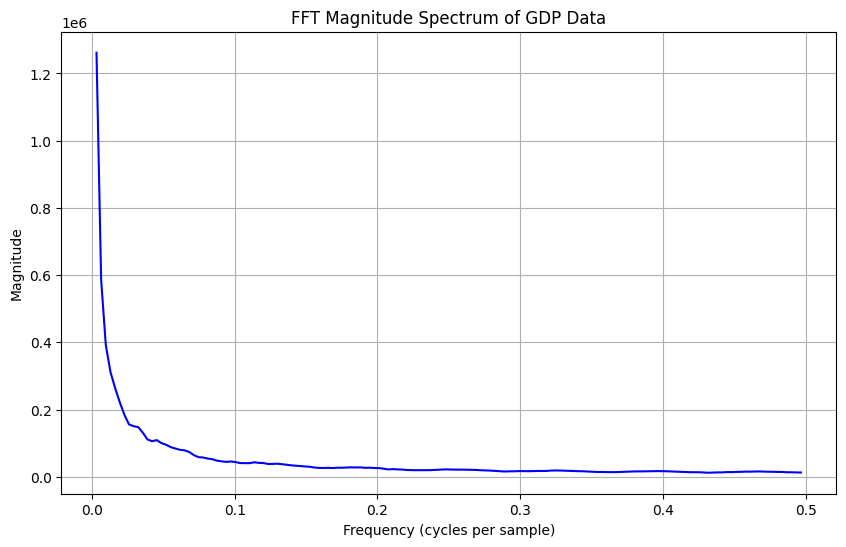

Dominant frequency (cycles per sample): 0.003246753246753247
Estimated seasonal period (in number of samples): 308.0


In [16]:
# Identify seasonal components and determine P, D, Q, s parameters
# 

# How to idenify seasonal components? We plan to use FFT for those reasons:
# > FFT transforms time-domain signal into its frequency components.
# > It helps in isolating and quantifying periodic patterns or cycles.
# > Just see the spikes in FFT plots to identify the seasonal components.

# Compute FFT of the data.
fft_data = dataframe_gdp["GDP_Billion"] - dataframe_gdp["GDP_Billion"].mean()
fft_values = np.fft.fft(fft_data.values)
fft_freq = np.fft.fftfreq(len(fft_data.values))

# Calculate magnitude of FFT coefficients.
fft_magnitude = np.abs(fft_values)

# Plot the magnitude spectrum (considering only the positive frequencies).
half_n = len(fft_data.values) // 2
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[1:half_n], fft_magnitude[1:half_n], color='blue')
plt.xlabel("Frequency (cycles per sample)")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude Spectrum of GDP Data")
plt.grid(True)
plt.show()

# Ignore the zero frequency (mean) and find the index of the highest magnitude in positive frequencies.
fft_magnitude[0] = 0
dominant_index = np.argmax(fft_magnitude[:half_n])
dominant_freq = fft_freq[dominant_index]

# Determine the seasonal period in number of samples (period = 1 / frequency).
if dominant_freq == 0:
    seasonal_period = None
else:
    seasonal_period = 1 / abs(dominant_freq)

print("Dominant frequency (cycles per sample):", dominant_freq)
print("Estimated seasonal period (in number of samples):", seasonal_period)

# Result interpretion:
# FFT estimates the period is 308 quarters (which means there does not exist some significant seasonal effect).
# This result is robust. You may alternatively try 
#   dataframe_gdp["GDP_Billion_d1"]
#     or
#   dataframe_gdp["GDP_Billion"].pct_change()
# , they will give similar results.

In [17]:
# Justify your choice of the linear model you are using and its parameters
# 

# Use the analysis above, I choose to use ARIMA(p, d, q) instead of SARIMA(p, d, q)(P, D, Q, S).
# > First, for seasonality, logically, there is NO seasonality (seasonal waves) for quarterly US GDP data, 
#   since GDP is non-stationarily growing, and for large countries like the US, macroeconomic conditions
#   are quite stable over seasons. Moreover, our FFT also indicates that NO seasonality is observed.
# > Second, for differencing, by leveraging Augmented Dickey-Fuller test and plots, we found when we difference 
#   the original data just for once, the data has become largely stationary (while still a little growing trend is 
#   observed). Although the statistical results indicate it satisfies wide-sense stationarity, we regard this was
#   caused by fluctuations in 2020 year, which somehow amplifies the trend and disturbs the statistical result.
#   By doing research on the plot, we decide to stop differencing after doing for 2 times.
# > Third, for AR/MA parameters, we leveraged ACF/PACF plots and found spikes in the 1st order and first two orders respectively.
#   There is NO linearity in the plots, meaning the data differenced by twice has already been stationary.
#                                                                                                           p, q
#   And they both decrease exponentially after the spike, which indicates the spike is meaningful for us - (2, 1).
# 
#                                                   p, d, q
# In conclusion, the model I choose to use is ARIMA(2, 2, 1).

`3. Model Training & Evaluation `

In [115]:
# Split the data into training (80%) and test (20%) sets
#

# Let's use our MLBase to conduct time-series splitting, 
# which avoids data leakage by ensuring that testing data is not 
# included in the training data.
train_data, test_data, _, _ = MLBase().train_test_split_for_timeseries(Matrix(dataframe_gdp["GDP_Billion"]), Matrix(dataframe_gdp["GDP_Billion"]), 0.15)
train_data, test_data

(Matrix(backend=numpy, shape=(262,), data=
 [  243.164   245.968   249.585   259.745   265.742   272.567   279.196
    280.366   275.034   271.351   272.889   270.627   280.828   290.383
    308.153   319.945   336.      344.09    351.385   356.178   359.82
    361.03    367.701   380.812   387.98    391.749   391.171   385.97
    385.345   386.121   390.996   399.734   413.073   421.532   430.221
    437.092   439.746   446.01    451.191   460.463   469.779   472.025
    479.49    474.864   467.54    471.978   485.841   499.555   510.33
    522.653   525.034   528.6     542.648   541.08    545.604   540.197
    545.018   555.545   567.664   580.612   594.013   600.366   609.027
    612.28    621.672   629.752   644.444   653.938   669.822   678.674
    692.031   697.319   717.79    730.191   749.323   771.857   795.734
    804.981   819.638   833.302   844.17    848.983   865.233   881.439
    909.387   934.344   950.825   968.03    993.337  1009.02   1029.956
   1038.147  1051.2    1

In [ ]:
# Train your selected linear model on the training data
#

# Train ARIMA(2, 2, 1) on my training data.
def train_arima(train_data: Matrix, use: str = "my", p=2, d=2, q=1):
    """
    Trains an ARIMA model based on the specified parameters.

    Args:
        train_data (Matrix): The training data for the ARIMA model.
        use (str, optional): Method to use for training. Can be 'my' or another method name. Defaults to "my".
        p (int, optional): Number of autoregressive terms. Defaults to 2.
        d (int, optional): Number of differencing steps. Defaults to 2.
        q (int, optional): Number of moving average terms. Defaults to 1.

    Returns:
        ARIMAX or smARIMA: The trained ARIMA model based on the specified method and parameters.

    Raises:
        ValueError: If an unsupported use method is provided.
    
    """
    if use == "my":
        arima_model_my = ARIMAX(p, d, q)
        arima_model_my.fit(train_data, ma_method="kalman")
        return arima_model_my
    else:
        arima_model = smARIMA(train_data.to("numpy").data, order=(p, d, q)).fit()
        return arima_model
    
# Forecast ARIMA(2, 2, 1) model by n steps.
def forecast_arima(model: Any, use: str = "my", steps: int = 50) -> Matrix:
    """
    Forecasts future values using the provided ARIMA model.

    Args:
        model (Any): The trained ARIMA model.
        use (str, optional): Method to use for forecasting. Can be 'my' or another method name. Defaults to "my".
        steps (int, optional): Number of forecasted steps ahead. Defaults to 5.

    Returns:
        Matrix: A matrix containing the forecasted values.

    Raises:
        ValueError: If an unsupported use method is provided.
    
    """
    if use == "my":
        return model.predict(steps=steps).flatten()
    else:
        return Matrix(model.forecast(steps=steps))

# Plot ARIMA(2, 2, 1) prediction and real data.
def plot_arima_pred(train_data: Matrix, test_data: Matrix, pred_data: Matrix, steps: int = 50, use:str = "my"):

    # Create a dataframe containing all real data.
    df_toplot = pd.DataFrame({"real_GDP": train_data.append(test_data[:steps]).flatten().to("numpy").data})

    # Append the test data into a next columns.
    df_toplot["pred_GDP"] = Matrix(np.repeat(np.NaN, train_data.shape[0]), "numpy").append(pred_data[:steps]).flatten().to("numpy").data

    # Plot realGDP and predGDP.
    plt.figure(figsize=(10, 5))
    plt.plot(df_toplot.index, df_toplot['real_GDP'], label="Real GDP", color='blue', linestyle='-')
    plt.plot(df_toplot.index, df_toplot['pred_GDP'], label="Predicted GDP", color='red', linestyle='--')

    plt.xlabel("Time Steps")
    plt.ylabel("GDP Value")
    plt.title(f"Real vs Predicted GDP using backend {use}")
    plt.legend()
    plt.grid(True)
    plt.show()

my_arima_model = train_arima(train_data=train_data, use = "my")
sm_arima_model = train_arima(train_data=train_data, use = "sm")

My ARIMA(2, 2, 1) RMSE: 1224.99
My ARIMA(2, 2, 1) MAE : 713.07
My ARIMA(2, 2, 1) MAPE: 0.0294


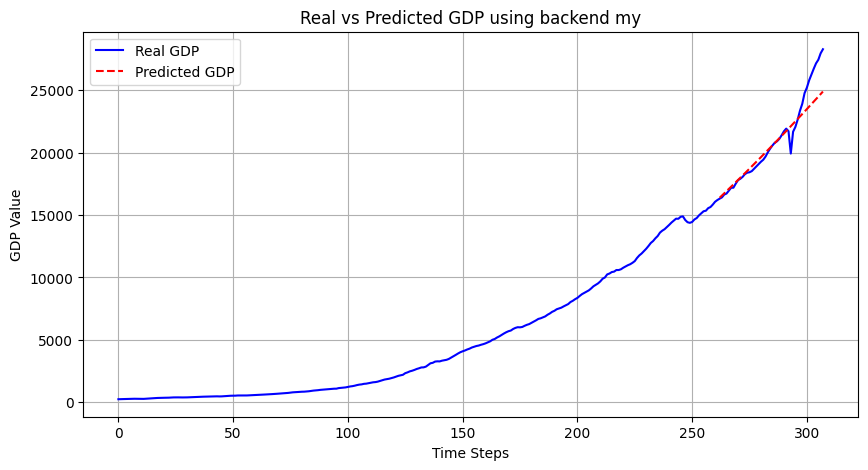

In [126]:
# Generate forecasts for the test period - my implementation and evaluation
# 

# Predict the future 50 periods and plot the forecast.
my_arima_pred = forecast_arima(my_arima_model, use = "my", steps = 46)

# Evaluate the results using RMSE, MAE, MAPE.
print(f"My ARIMA(2, 2, 1) RMSE: {round(float(RegressionMetrics(my_arima_pred, test_data, 'RMSE').compute().data), 2)}")
print(f"My ARIMA(2, 2, 1) MAE : {round(float(RegressionMetrics(my_arima_pred, test_data, 'MAE' ).compute().data), 2)}")
print(f"My ARIMA(2, 2, 1) MAPE: {round(float(RegressionMetrics(my_arima_pred, test_data, 'MAPE').compute().data), 4)}")

# Plot a graph showing the prediction result.
plot_arima_pred(train_data, test_data, my_arima_pred, steps = 46, use = "my")


Statsmodels ARIMA(2, 2, 1) RMSE: 2514.71
Statsmodels ARIMA(2, 2, 1) MAE : 1713.32
Statsmodels ARIMA(2, 2, 1) MAPE: 0.0713


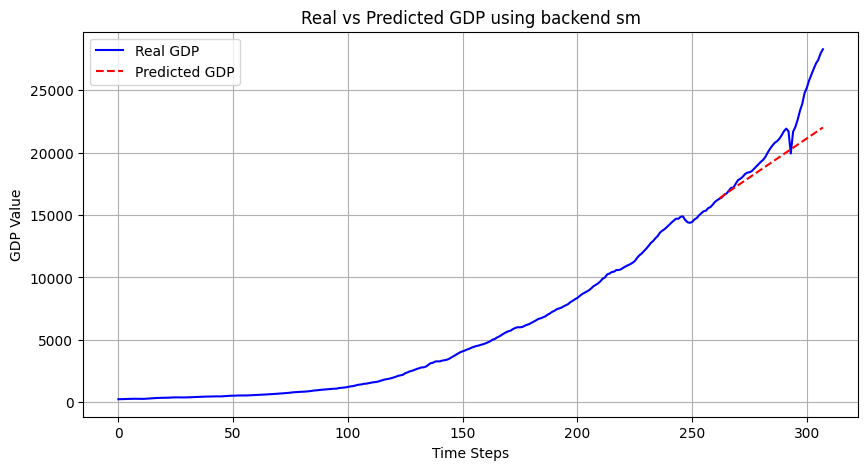

In [127]:
# Generate forecasts for the test period - statsmodels implementation
# 

# Predict the future 50 periods and plot the forecast
sm_arima_pred = forecast_arima(sm_arima_model, use = "sm", steps = 46)

# Evaluate the results using RMSE, MAE, MAPE.
print(f"Statsmodels ARIMA(2, 2, 1) RMSE: {round(float(RegressionMetrics(sm_arima_pred, test_data, 'RMSE').compute().data), 2)}")
print(f"Statsmodels ARIMA(2, 2, 1) MAE : {round(float(RegressionMetrics(sm_arima_pred, test_data, 'MAE' ).compute().data), 2)}")
print(f"Statsmodels ARIMA(2, 2, 1) MAPE: {round(float(RegressionMetrics(sm_arima_pred, test_data, 'MAPE').compute().data), 4)}")

# Plot a graph showing the prediction result.
plot_arima_pred(train_data, test_data, sm_arima_pred, steps = 46, use = "sm")

In [ ]:
# Provide detailed interpretation of each metric
# 

# > RMSE (Root Mean Squared Error) reflects the square root of the average squared deviations 
#   between the forecasted and actual values, emphasizing larger errors more strongly, 
#   and a lower RMSE indicates a model that performs better on average. 
# > MAE (Mean Absolute Error) measures the average magnitude of errors in the same units as the 
#   data, giving us a straightforward interpretation of forecast accuracy without squaring the deviations, 
#   still, lower is better. 
# > MAPE (Mean Absolute Percentage Error) measures the average absolute error as a percentage of the 
#   actual values, providing insight into the error relative to the magnitude of the observations.
# 
# In my results, a MAPE of 0.0294 suggests that the errors are around 2.9% of the actual values on average, 
#   which is very low. My results also indicate a MAE of 1170.41
# The Statsmodels ARIMA(2, 2, 1) displays higher RMSE and MAE values compared to my ARIMA implementation.
# Comparison:
#          MY             Statsmodels
# RMSE     1224.99        2514.71
# MAE       713.07        1713.32
# MAPE      0.0294         0.0713

# We can observe that linear models, while capture the long term growing trend, it fails to capture some
# short-term shocks like the COVID pandemic in 2020. 
# We may need further advancement like SARIMAX to make it better.

`4. Comparative Analysis`

In [195]:
# Train a second model - SARIMAX - using lagged CPI change ratio as a control variable
# 

# Why using CPI change ratio as the control variable?
# It acts as a:
# > Inflationary Pressure: Lagged changes in the CPIcan reflect past inflation trends that influence current economic conditions and future GDP growth.
# > Monetary Policy Impact: Changes in CPI over time can indicate how monetary policy adjustments have affected price levels, which in turn impacts real GDP.
# > Demand-Side Indicators: CPI changes provide insights into consumer spending power and overall demand, which are crucial for predicting GDP trends.
# > Stabilization Effects: Lagged CPI data can help assess the effectiveness of past economic policies aimed at stabilizing prices.
# > Easy to Predict: CPI may largely be affected by government's moneytary policies and is eaiser to predict.

# Define the CPI URL.
cpi_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/CPI_USD_Quarterly.csv'

# Load the raw CPI dataset into a pandas DataFrame.
raw_cpi = pd.read_csv(cpi_url)

# Convert the "observation_date" column to string type and set it as the index of the DataFrame.
raw_cpi["observation_date"] = raw_cpi["observation_date"].astype(str)
raw_cpi.index = raw_cpi["observation_date"]

# Extract only the "CPI" column from the DataFrame.
raw_cpi = raw_cpi["CPI"]

# Select and store a subset of the GDP data between January 1947 and October 2023. 
selected_cpi = raw_cpi.loc["1947-01-01":"2023-10-01"]

# Retransform into a DataFrame.
dataframe_cpi = pd.DataFrame(selected_cpi)
dataframe_cpi.index = pd.to_datetime(dataframe_cpi.index) 

# Resample to quarterly using last().
quarterly_cpi = dataframe_cpi.resample('QE').last()

# Compute CPI_Ratio by pct_change() method
quarterly_cpi["CPI_Ratio"] = quarterly_cpi["CPI"].pct_change().fillna(0)
quarterly_cpi["CPI_Ratio_l1"] = quarterly_cpi["CPI"].pct_change().shift(1).fillna(0)

# Extend the CPI dataframe by GDP data.
quarterly_cpi["GDP_Billion"] = dataframe_gdp["GDP_Billion"].to_list()
quarterly_cpi

,CPI,CPI_Ratio,CPI_Ratio_l1,GDP_Billion
observation_date,,,,
1947-03-31,22.000,0.000000,0.000000,243.164
1947-06-30,22.080,0.003636,0.000000,245.968
1947-09-30,22.840,0.034420,0.003636,249.585
1947-12-31,23.410,0.024956,0.034420,259.745
1948-03-31,23.500,0.003845,0.024956,265.742
...,...,...,...,...
2022-12-31,298.808,0.008053,0.004572,26734.277
2023-03-31,301.643,0.009488,0.008053,27164.359
2023-06-30,304.099,0.008142,0.009488,27453.815


My ARIMA(2, 2, 1) RMSE: 1058.79
My ARIMA(2, 2, 1) MAE : 671.99
My ARIMA(2, 2, 1) MAPE: 0.0285


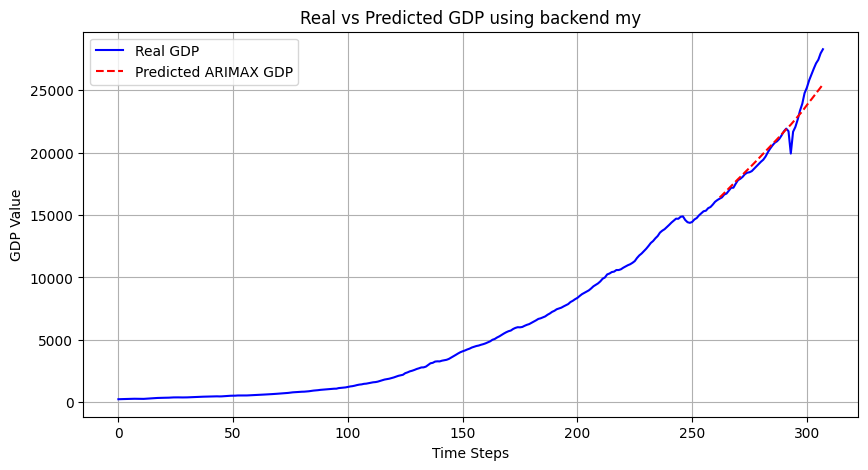

In [199]:
# Train a second model - SARIMAX - using lagged CPI change ratio as a control variable
#

# Let's use our MLBase to conduct time-series splitting, 
# which avoids data leakage by ensuring that testing data is not 
# included in the training data.
train_data, test_data, _, _ = MLBase().train_test_split_for_timeseries(Matrix(quarterly_cpi.to_numpy()), Matrix(quarterly_cpi.to_numpy()), 0.15)
train_data, test_data

# Train ARIMAX(2, 2, 1) on my training data.
def train_arimax(train_data: Matrix, exog:Matrix, use: str = "my", p=2, d=2, q=1):
    """
    Trains an ARIMA model based on the specified parameters.

    Args:
        train_data (Matrix): The training data for the ARIMA model.
        exog (Matrix): The exogenous data for the SARIMA model.
        use (str, optional): Method to use for training. Can be 'my' or another method name. Defaults to "my".
        p (int, optional): Number of autoregressive terms. Defaults to 2.
        d (int, optional): Number of differencing steps. Defaults to 2.
        q (int, optional): Number of moving average terms. Defaults to 1.

    Returns:
        ARIMAX or smARIMA: The trained ARIMA model based on the specified method and parameters.

    Raises:
        ValueError: If an unsupported use method is provided.
    
    """
    if use == "my":
        arima_model_my = ARIMAX(p, d, q)
        arima_model_my.fit(train_data, exogenous=exog, ma_method="kalman")
        return arima_model_my
    else:
        raise NotImplementedError("Please use `my` to conduct ARIMAX regression.")
    
# Forecast ARIMAX(2, 2, 1) model by n steps.
def forecast_arimax(model: Any, exog:Matrix, use: str = "my", steps: int = 50) -> Matrix:
    """
    Forecasts future values using the provided ARIMA model.

    Args:
        model (Any): The trained ARIMA model.
        exog (Matrix): The exogenous data for the SARIMA model.
        use (str, optional): Method to use for forecasting. Can be 'my' or another method name. Defaults to "my".
        steps (int, optional): Number of forecasted steps ahead. Defaults to 5.

    Returns:
        Matrix: A matrix containing the forecasted values.

    Raises:
        ValueError: If an unsupported use method is provided.
    
    """
    if use == "my":
        return model.predict(steps=steps, exogenous_future=exog).flatten()
    else:
        raise NotImplementedError("Please use `my` to conduct ARIMAX regression.")

# Plot ARIMAX(2, 2, 1) prediction and real data.
def plot_arimax_pred(train_data: Matrix, test_data: Matrix, pred_data: Matrix, steps: int = 50, use:str = "my"):

    # Create a dataframe containing all real data.
    df_toplot = pd.DataFrame({"real_GDP": train_data.append(test_data[:steps]).flatten().to("numpy").data})

    # Append the test data into a next columns.
    df_toplot["pred_GDP"] = Matrix(np.repeat(np.NaN, train_data.shape[0]), "numpy").append(pred_data[:steps]).flatten().to("numpy").data

    # Plot realGDP and predGDP.
    plt.figure(figsize=(10, 5))
    plt.plot(df_toplot.index, df_toplot['real_GDP'], label="Real GDP", color='blue', linestyle='-')
    plt.plot(df_toplot.index, df_toplot['pred_GDP'], label="Predicted ARIMAX GDP", color='red', linestyle='--')

    plt.xlabel("Time Steps")
    plt.ylabel("GDP Value")
    plt.title(f"Real vs Predicted GDP using backend {use}")
    plt.legend()
    plt.grid(True)
    plt.show()

my_arimax_model = train_arimax(train_data=train_data[:,3], exog=train_data[:,0:3], use = "my")
# Predict the future 50 periods and plot the forecast.
my_arimax_pred = forecast_arimax(my_arimax_model, exog=test_data[:,0:3], use = "my", steps = 46)

# Evaluate the results using RMSE, MAE, MAPE.
print(f"My ARIMA(2, 2, 1) RMSE: {round(float(RegressionMetrics(my_arimax_pred, test_data[:,3], 'RMSE').compute().data), 2)}")
print(f"My ARIMA(2, 2, 1) MAE : {round(float(RegressionMetrics(my_arimax_pred, test_data[:,3], 'MAE' ).compute().data), 2)}")
print(f"My ARIMA(2, 2, 1) MAPE: {round(float(RegressionMetrics(my_arimax_pred, test_data[:,3], 'MAPE').compute().data), 4)}")

# Plot a graph showing the prediction result.
plot_arimax_pred(train_data[:,3], test_data[:,3], my_arimax_pred, steps = 46, use = "my")

In [ ]:
# Compare performance with your first model
# and 
# Discuss strengths and weaknesses of each approach

# Comparison:
#          MY ARIMA       MY ARIMAX    Statsmodels
# RMSE     1224.99        1058.79      2514.71
# MAE       713.07        671.99       1713.32
# MAPE      0.0294        0.0285       0.0713

# Here are some descriptive comments:
# > My ARIMAX performs best, with the lowest RMSE (1058.79), MAE (671.99), and MAPE (0.0285).
# > My ARIMA is decent, but slightly worse than ARIMAX in all metrics.
# > Statsmodels performs the worst, with significantly higher errors across all measures.
# 
# The reason why  SARIMAX predicts better primarily because it leverages the additional information from the CPI and its change ratio,
#   which provides an economic context that a pure ARIMA model lacks. By incorporating the CPI as a control variable, 
#   the model captures inflationary pressure and monetary policy impacts that are critical for forecasting GDP trends. 
# The lagged CPI data reflect past inflation trends, offering insights into consumer demand and the effectiveness of stabilization policies, 
#   which in turn help to predict future GDP movements more accurately.
# Moreover, since CPI changes are often influenced by predictable government policies, 
#   they offer a reliable signal that enhances the overall forecasting performance.

# Discussion about strength and weakness:
# > ARIMA is straightforward and computationally efficient. But since it is a pure autoregressive model, 
#   it lacks the capacity to account for external economic signals, like government policies reflected into CPI,
#   leading to less accurate forecasts. 
# > On the other hand, ARIMAX incorporates CPI as a control variable, enhancing its ability to capture 
#   inflationary trends and monetary policy effects, though it demands more complex data handling and calibration.
#   And to achieve a better result by using CPI, sometimes, predicting CPI is another heavy task.
# > For statsmodels, it usually provides a robust, off-the-shelf solution.
#   But in this context, its generic nature results in poorer performance compared to your tailored approaches.

`End of Homework 1 Q1 by Nathmath Huang (bh2821)`